# Definitions

In [116]:
# Metrics
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import zip_longest
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
np.set_printoptions(threshold=1000)

## Formatter

In [4]:
def fmt(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 100000)
    return s

yfmt = tkr.FuncFormatter(numfmt)

def numfmt2(x, pos): # your custom formatter function: divide y axis tick labels by 1000.0
    s = '{}'.format(x / 1000)
    return s

yfmt2 = tkr.FuncFormatter(numfmt2)

def numfmt3(x, pos): # your custom formatter function: divide y axis tick labels by 10000000.0
    s = '{}'.format(x / 10000000)
    return s
yfmt3 = tkr.FuncFormatter(numfmt3)

def numfmt4(x, pos): # your custom formatter function: multiply y axis tick labels by 100.0
    s = '{}'.format(x * 100)
    return s

yfmt4 = tkr.FuncFormatter(numfmt4)

def minutes(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 60000)
    return s

def ms_to_sec(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 1000)
    return s

def sec_to_min(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{:.2f}'.format(x / 60)
    return s

In [182]:
def plot_aggregated_dict(title, inputs, labels, markers, linestyles, colors, fit_degree=None, formatter=None, ylabel=None, xlabel=None, pre_fig=None):
    x = np.array(sorted(inputs[0].keys()))
    y = list(map(lambda x: np.array([]), inputs))
    lines = list()
    for key in x:
        for i, _ in enumerate(y):
            if key not in inputs[i]:
                inputs[i][key] = 0
            val = np.array(inputs[i][key])
            y[i] = np.append(y[i], val)
    fig, ax = plt.subplots() if pre_fig is None else pre_fig
    for i, yi in enumerate(y):
        if fit_degree:
            theta = np.poly1d(np.polyfit(x, y[i], fit_degree))
            fit_line = theta(x)
            lines.append(ax.scatter(x, yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i]))
            lines.append(ax.plot(x, fit_line, label=None, marker=None, linestyle=":")[0])
            
        else:
            lines.append(ax.plot(x, yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i])[0])
    if formatter is not None:
        ax.yaxis.set_major_formatter(formatter)
    ax.set_title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return (fig, ax, lines)

## Plotter


## Statistics Measurer

In [177]:
class MetricStatistics:
    def __init__(self, entry_folder_name="metrics", operator_name="GNN Operator - 2", metric_name="numRecordsInPerSecond", is_lambda=False):
        """ 
        Folders are organized as follows:
        entry_folder -> run -> operator_name -> metric_name -> subtask_index[digit]
        Output is as follows:
        parallelism -> experiments[] -> subtask[] -> metric_values[]
        """
        self.output = defaultdict(list)
        for run in os.listdir(entry_folder_name):
            if not os.path.isdir(os.path.join(entry_folder_name, run)):
                continue
            subtasks = []
            for subtask_index in (os.listdir(os.path.join(entry_folder_name, run, operator_name, metric_name))):
                if not subtask_index.isdigit():
                    continue
                f = pd.read_csv(os.path.join(entry_folder_name, run, operator_name, metric_name,subtask_index), header=None, names=["value"])
                subtasks.append(f["value"].values)
                
            run_class = int(re.match(".*\((\d+)\).*",run).groups()[0]) if not is_lambda else float(re.match(".*-l=(\d+.\d+).*",run).groups()[0])
            self.output[run_class].append(subtasks)
    def transform_metrics(self,transformation) -> MetricStatistics:
        """ Apply Transformation to each metric array in a subtask """
        for experiments in self.output.values():
            for experiment in experiments:
                for subtask_index in range(len(experiment)):
                    if callable(transformation):
                        experiment[subtask_index] = transformation(experiment[subtask_index])
                    elif transformation == "trim_zeros":
                        experiment[subtask_index] = np.trim_zeros(experiment[subtask_index],"fb")
                            
        return self
        
    def transform_subtasks(self, transformation) -> MetricStatistics:
        """ Apply transformation to all subtasks """
        for experiments in self.output.values():
            for experiment_index in range(len(experiments)):
                if callable(transformation):
                    experiments[experiment_index] = transformation(experiments[experiment_index])
                elif transformation == "sum_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.sum(output, axis=0)
                elif transformation == "mean_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.mean(output, axis=0)
                elif transformation == "max_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.max(output, axis=0)
        return self
    
    def transform_experiment(self, transformation) -> MetricStatistics:
        """ Apply transformation to all experiments """
        for key, experiments in self.output.items():
            if callable(transformation):
                self.output[key] = transformation(experiments)
            elif transformation == "mean_0_axis":
                max_len = max([len(x) for x in experiments])
                output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments])
                self.output[key] = np.mean(output, axis=0)
        return self
    
    def get_mean_throughput(self):
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("sum_0_axis")
        self.transform_subtasks(lambda x: [x.mean()])
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
        
        
    

## Process Folder

In [178]:
a = MetricStatistics(entry_folder_name="../../jupyter/metrics/DBLP_edge_streaming_streaming/", metric_name="throughput").transform_metrics("trim_zeros").transform_subtasks("mean")

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'tt'}>,
 [<matplotlib.lines.Line2D at 0x178b46a30>])

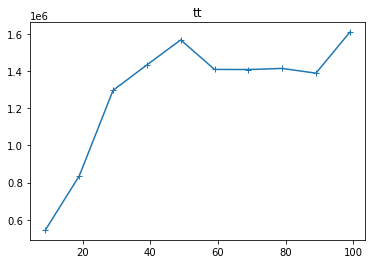

In [191]:
plot_aggregated_dict("tt",[a.output], ["a"], ["+"], ["-"], [None], formatter=)

## Aggregate